In [1]:
import time

In [2]:
#%%timeit -n 1 -r 1
start = time.perf_counter()

import torch

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

Elapsed time: 71.621321 seconds


In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

Matplotlib is building the font cache; this may take a moment.


# Device Info

In [4]:
torch.__version__

'2.4.1'

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.get_device_name()

'NVIDIA L40S'

In [7]:
torch.cuda.list_gpu_processes()

'GPU:0\nno processes are running'

In [8]:
torch.cuda.device_count()

1

In [9]:
# See https://github.com/seafoodfry/ml-workspace/blob/main/gpu-sandbox/our-cuda-by-example/03-cudaDeviceProp.cu
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA L40S', major=8, minor=9, total_memory=45372MB, multi_processor_count=142)

In [10]:
# See https://arnon.dk/matching-sm-architectures-arch-and-gencode-for-various-nvidia-cards/
torch.cuda.get_arch_list()

['sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']

In [11]:
# See
# https://pytorch.org/docs/stable/notes/cuda.html#optimizing-memory-usage-with-pytorch-cuda-alloc-conf
# and
# https://developer.nvidia.com/blog/using-cuda-stream-ordered-memory-allocator-part-1/
torch.cuda.get_allocator_backend()

'native'

In [12]:
# See https://pytorch.org/docs/stable/notes/mps.html
torch.backends.mps.is_available()

False

In [13]:
torch.backends.cuda.is_built()

True

In [14]:
torch.backends.cpu.get_cpu_capability()

'AVX2'

In [15]:
torch.tensor([1])

tensor([1])

In [16]:
torch.tensor([1, 2, 3])

tensor([1, 2, 3])

In [17]:
torch.tensor([
    [1, 2, 3],
    [4, 5, 6],
])

tensor([[1, 2, 3],
        [4, 5, 6]])

In [18]:
# 3D.
torch.tensor([
    [
        [1, 2, 3],
        [4, 5, 6],
    ],
    [
        [7, 8, 9],
        [10, 11, 12],
    ]
])

tensor([[[ 1,  2,  3],
         [ 4,  5,  6]],

        [[ 7,  8,  9],
         [10, 11, 12]]])

In [19]:
torch.tensor([1]).dtype

torch.int64

In [20]:
torch.tensor([1]).to(torch.float32).dtype

torch.float32

In [21]:
torch.tensor([1.0]).dtype

torch.float32

# Forward pass (prediciton step) of a simple logistic regression classifier

In [4]:
import torch.nn.functional as F

In [6]:
# True label.
y = torch.tensor([1.0])

# Input feature.
x1 = torch.tensor([1.1])
w1 = torch.tensor([2.2])
b = torch.tensor([0.1])

z = x1 * w1 + b

activation = torch.sigmoid(z)

loss = F.binary_cross_entropy(activation, y)
loss

tensor(0.0774)

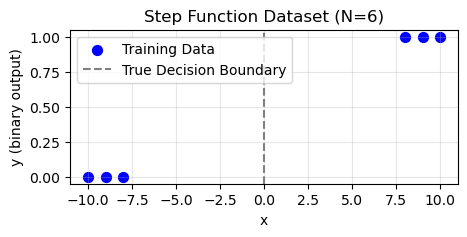

In [7]:
# Create a clear step-function dataset.
x = torch.tensor([[-10.0], [-9.0], [-8.0], [8.0], [9.0], [10.0]], dtype=torch.float32)
y = torch.tensor([[0.0], [0.0], [0.0], [1.0], [1.0], [1.0]], dtype=torch.float32)

# Visualize the dataset
plt.figure(figsize=(5, 2))
plt.scatter(x, y, c='blue', s=50, label='Training Data')
plt.axvline(x=0.0, color='gray', linestyle='--', label='True Decision Boundary')
plt.grid(True, alpha=0.3)
plt.title('Step Function Dataset (N=6)')
plt.xlabel('x')
plt.ylabel('y (binary output)')
plt.legend()
plt.show()

In [9]:
# Model parameters
w = torch.tensor([[0.9]], requires_grad=True)
b = torch.tensor([[-0.2]], requires_grad=True)

def net_input(x, w, b):
    return x @ w.T + b

# Hyperparameters.
learning_rate = 0.1
num_epochs = 100

# Training loop.
losses = []
accuracies = []
print("Training Progress:")
for epoch in tqdm(range(num_epochs)):
    # Forward pass.
    z = net_input(x, w, b)
    
    # Compute the activation / predicitons.
    activation = torch.sigmoid(z)
    
    # Compute loss.
    loss = F.binary_cross_entropy(activation, y)
    
    # Backward pass.
    # PyTorch's way of implementing backpropagation. It calculates the gradient of the loss
    # with respect to all parameters that have requires_grad=True.
    loss.backward()
    
    # Update parameters.
    # Temporarily disable gradient tracking.
    with torch.no_grad():
        # SGD-like algorithm.
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad
        w.grad.zero_()
        b.grad.zero_()

    # Compute accuracy.
    predicted_labels = (activation >= 0.5).float()
    accuracy = (predicted_labels == y).float().mean()

    # Store metrics.
    losses.append( loss.item() )
    accuracies.append( accuracy.item() )
    
    # Print progress every 20 epochs.
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}: Loss = {loss.item():.4f}, Accuracy = {accuracy.item():.2f}')

print("\nFinal Parameters:")
print(f"Weight (w): {w.item():.4f}")
print(f"Bias (b): {b.item():.4f}")

Training Progress:


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4893.94it/s]

Epoch 20: Loss = 0.0004, Accuracy = 1.00
Epoch 40: Loss = 0.0004, Accuracy = 1.00
Epoch 60: Loss = 0.0003, Accuracy = 1.00
Epoch 80: Loss = 0.0003, Accuracy = 1.00
Epoch 100: Loss = 0.0003, Accuracy = 1.00

Final Parameters:
Weight (w): 0.9297
Bias (b): -0.1993


## Quick detour: compressing the X axis in a plot

In [7]:
test_x_axis = np.array([x for x in range(10)])
test_x_axis

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
early, late = 1, 8
mask_early = test_x_axis < early
mask_middle = (test_x_axis >= early) & (test_x_axis < late)
mask_late = test_x_axis >= late

mask_early, mask_middle, mask_late

(array([ True, False, False, False, False, False, False, False, False,
        False]),
 array([False,  True,  True,  True,  True,  True,  True,  True, False,
        False]),
 array([False, False, False, False, False, False, False, False,  True,
         True]))

In [9]:
test_result = np.zeros_like(test_x_axis, dtype=float)
scale_middle = 0.1

test_result[mask_early] = test_x_axis[mask_early]
test_result

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
test_x_axis[mask_middle]

array([1, 2, 3, 4, 5, 6, 7])

In [11]:
test_x_axis[mask_middle] * 0.1

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [12]:
(test_x_axis[mask_middle]-early) * 0.1

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

In [13]:
# The minus before the multiplication preserves the point at which we start compressing
# the x axis.
early + (test_x_axis[mask_middle] - early) * 0.1

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6])

In [15]:
test_result[mask_middle] = ( early + (test_x_axis[mask_middle] - early) * scale_middle )

test_x_axis[mask_middle], test_result

(array([1, 2, 3, 4, 5, 6, 7]),
 array([0. , 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 0. , 0. ]))

In [12]:
def custom_scale(x, early=10, late=90):
    """Create a custom scale that compresses the middle section."""
    x = np.array(x)
    
    # Create scaling factors.
    scale_early = 1.0  # Normal scale for early epochs
    scale_middle = 0.1  # Compressed scale for middle epochs
    scale_late = 1.0   # Normal scale for late epochs
    
    result = np.zeros_like(x, dtype=float)
    
    # Apply different scales to different regions.
    mask_early = x < early
    mask_middle = (x >= early) & (x < late)
    mask_late = x >= late
    
    # Early region: normal scale.
    result[mask_early] = x[mask_early] + scale_early
    
    # Middle region: compressed.
    result[mask_middle] = early + (x[mask_middle] - early) * scale_middle
    
    # Late region: normal scale but shifted due to compression.
    middle_width = (late - early) * scale_middle
    result[mask_late] = early + middle_width + (x[mask_late] - late) * scale_late
    
    return result

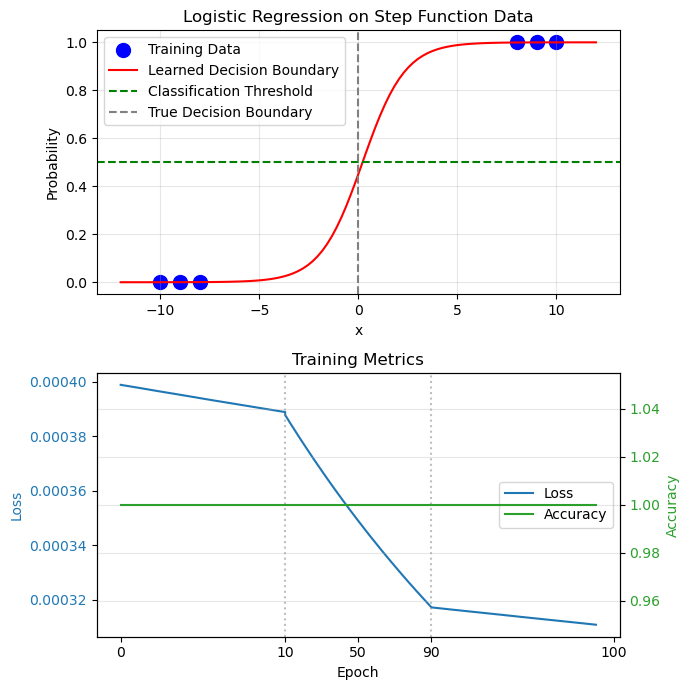

In [13]:
plt.figure(figsize=(7, 7))

#############################
# Plot 1: Decision Boundary #
#############################
plt.subplot(2, 1, 1)
# Plot training data.
plt.scatter(x, y, c='blue', s=100, label='Training Data')

# Plot decision boundary.
x_plot = torch.linspace(-12, 12, 100).reshape(-1, 1)
with torch.no_grad():
    z_plot = net_input(x_plot, w, b)
    y_plot = torch.sigmoid(z_plot)

plt.plot(x_plot, y_plot, 'r-', label='Learned Decision Boundary')
plt.axhline(y=0.5, color='g', linestyle='--', label='Classification Threshold')
plt.axvline(x=0.0, color='gray', linestyle='--', label='True Decision Boundary')

plt.grid(True, alpha=0.3)
plt.title('Logistic Regression on Step Function Data')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()

#################################
# Second row: Loss and Accuracy #
#################################
plt.subplot(2, 1, 2)

epochs = np.arange(len(losses))
epochs_scaled = custom_scale(epochs)

# Plot loss on primary y-axis.
color_loss = 'tab:blue'
ax1 = plt.gca() # get current axis.
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color_loss)
ln1 = ax1.plot(epochs_scaled, losses, color=color_loss, label='Loss')
ax1.tick_params(axis='y', labelcolor=color_loss)

# Plot accuracy on secondary y-axis.
color_acc = 'tab:green'
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color=color_acc)
ln2 = ax2.plot(epochs_scaled, accuracies, color=color_acc, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color_acc)

# Set custom ticks to show actual epoch numbers.
tick_locations = custom_scale([0, 10, 50, 90, 100])
ax1.set_xticks(tick_locations)
ax1.set_xticklabels(['0', '10', '50', '90', '100'])

# Add markers to show scale change.
for _x in [10, 90]:
    scaled_x = custom_scale([_x])[0]
    ax1.axvline(x=scaled_x, color='gray', linestyle=':', alpha=0.5)

# Add legend.
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')

plt.title('Training Metrics')
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
# Print classification results
with torch.no_grad():
    z_test = net_input(x, w, b)
    probs = torch.sigmoid(z_test)
    predictions = (probs >= 0.5).float()
    
print("\nClassification Results:")
print("----------------------")
for i in range(len(x)):
    print(f"x = {x[i][0]:.1f}: probability = {probs[i][0]:.4f}, prediction = {predictions[i][0]:.0f}, true_label = {y[i][0]:.0f}")


Classification Results:
----------------------
x = -10.0: probability = 0.0001, prediction = 0, true_label = 0
x = -9.0: probability = 0.0002, prediction = 0, true_label = 0
x = -8.0: probability = 0.0005, prediction = 0, true_label = 0
x = 8.0: probability = 0.9993, prediction = 1, true_label = 1
x = 9.0: probability = 0.9997, prediction = 1, true_label = 1
x = 10.0: probability = 0.9999, prediction = 1, true_label = 1


In [15]:
from tabulate import tabulate

In [16]:
# Prepare the data for the table.
table_data = [
    [x[i][0], f"{probs[i][0]:.4f}", f"{1.0 - probs[i][0]:.4f}", predictions[i][0], y[i][0]]
    for i in range(len(x))
]

# Define column headers.
headers = ['x', 'Probability', 'Compliment', 'Prediction', 'True Label']

# Print the table
print(tabulate(table_data, headers=headers, tablefmt='grid'))

+-----+---------------+--------------+--------------+--------------+
|   x |   Probability |   Compliment |   Prediction |   True Label |
+=====+===============+==============+==============+==============+
| -10 |        0.0001 |       0.9999 |            0 |            0 |
+-----+---------------+--------------+--------------+--------------+
|  -9 |        0.0002 |       0.9998 |            0 |            0 |
+-----+---------------+--------------+--------------+--------------+
|  -8 |        0.0005 |       0.9995 |            0 |            0 |
+-----+---------------+--------------+--------------+--------------+
|   8 |        0.9993 |       0.0007 |            1 |            1 |
+-----+---------------+--------------+--------------+--------------+
|   9 |        0.9997 |       0.0003 |            1 |            1 |
+-----+---------------+--------------+--------------+--------------+
|  10 |        0.9999 |       0.0001 |            1 |            1 |
+-----+---------------+-----------

# Iris

In [22]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors.
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [24]:
class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = IrisDataset(X_train, y_train)
test_dataset = IrisDataset(X_test, y_test)

In [30]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(
    test_dataset, batch_size=32, num_workers=0, drop_last=False)

In [37]:
for idx, (x, _) in enumerate(train_loader):
    print(f'Batch {idx}: ', x.shape)

Batch 0:  torch.Size([32, 2])
Batch 1:  torch.Size([32, 2])
Batch 2:  torch.Size([32, 2])
Batch 3:  torch.Size([24, 2])


In [31]:
class IrisClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = IrisClassifier()

In [32]:
model

IrisClassifier(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
num_epochs = 1_000
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (epoch) % 100 == 0:
            print(f'Epoch:{epoch:03d}/{num_epochs:03d}'
                  f' | Batch: {i:03d}/{len(train_loader):03d}'
                  f' | Train Loss: {loss:.3f}',
            )

Epoch:000/1000 | Batch: 000/004 | Train Loss: 0.125
Epoch:000/1000 | Batch: 001/004 | Train Loss: 0.031
Epoch:000/1000 | Batch: 002/004 | Train Loss: 0.040
Epoch:000/1000 | Batch: 003/004 | Train Loss: 0.084
Epoch:100/1000 | Batch: 000/004 | Train Loss: 0.082
Epoch:100/1000 | Batch: 001/004 | Train Loss: 0.073
Epoch:100/1000 | Batch: 002/004 | Train Loss: 0.060
Epoch:100/1000 | Batch: 003/004 | Train Loss: 0.056
Epoch:200/1000 | Batch: 000/004 | Train Loss: 0.102
Epoch:200/1000 | Batch: 001/004 | Train Loss: 0.137
Epoch:200/1000 | Batch: 002/004 | Train Loss: 0.003
Epoch:200/1000 | Batch: 003/004 | Train Loss: 0.018
Epoch:300/1000 | Batch: 000/004 | Train Loss: 0.165
Epoch:300/1000 | Batch: 001/004 | Train Loss: 0.017
Epoch:300/1000 | Batch: 002/004 | Train Loss: 0.044
Epoch:300/1000 | Batch: 003/004 | Train Loss: 0.041
Epoch:400/1000 | Batch: 000/004 | Train Loss: 0.042
Epoch:400/1000 | Batch: 001/004 | Train Loss: 0.159
Epoch:400/1000 | Batch: 002/004 | Train Loss: 0.053
Epoch:400/10

In [42]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: %d %%' % (100 * correct / total))

Accuracy on test set: 100 %


In [43]:
# Taken from https://github.com/rasbt/machine-learning-book/blob/main/ch03/ch03.ipynb
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    #lab = classifier(np.array([xx1.ravel(), xx2.ravel()]).T)
    # UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow.
    # Please consider converting the list to a single numpy.ndarray with numpy.array()
    # before converting to a tensor.
    lab = classifier( torch.tensor(np.array([xx1.ravel(), xx2.ravel()]), dtype=torch.float32).T )
    #lab = lab.reshape(xx1.shape)
    _, predictions = torch.max(lab.data, 1)
    lab = predictions.numpy()
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')        

In [48]:
X_combined_std = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

In [49]:
X_combined_std[:3, :],

(array([[-1.5625348 , -1.3126028 ],
        [-1.2760063 , -1.0456327 ],
        [ 0.3858582 ,  0.28921756]], dtype=float32),)

In [50]:
X_train[:3, :]

tensor([[-1.5625, -1.3126],
        [-1.2760, -1.0456],
        [ 0.3859,  0.2892]])

In [51]:
x1_min, x1_max = X_combined_std[:, 0].min() - 1, X_combined_std[:, 0].max() + 1
x2_min, x2_max = X_combined_std[:, 1].min() - 1, X_combined_std[:, 1].max() + 1

In [52]:
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))

In [53]:
xx1

array([[-2.56253481, -2.54253481, -2.52253481, ...,  2.77746519,
         2.79746519,  2.81746519],
       [-2.56253481, -2.54253481, -2.52253481, ...,  2.77746519,
         2.79746519,  2.81746519],
       [-2.56253481, -2.54253481, -2.52253481, ...,  2.77746519,
         2.79746519,  2.81746519],
       ...,
       [-2.56253481, -2.54253481, -2.52253481, ...,  2.77746519,
         2.79746519,  2.81746519],
       [-2.56253481, -2.54253481, -2.52253481, ...,  2.77746519,
         2.79746519,  2.81746519],
       [-2.56253481, -2.54253481, -2.52253481, ...,  2.77746519,
         2.79746519,  2.81746519]])

In [54]:
xx1.ravel()

array([-2.56253481, -2.54253481, -2.52253481, ...,  2.77746519,
        2.79746519,  2.81746519])

In [57]:
lab = model( torch.tensor([xx1.ravel(), xx2.ravel()], dtype=torch.float32).T )
lab

tensor([[  9.9317,  -4.2587, -14.6105],
        [  9.8983,  -4.2308, -14.5695],
        [  9.8650,  -4.2028, -14.5286],
        ...,
        [-18.9482,  -7.9482,  18.2118],
        [-19.0212,  -8.0297,  18.3205],
        [-19.0943,  -8.1111,  18.4292]], grad_fn=<AddmmBackward0>)

In [58]:
lab.data

tensor([[  9.9317,  -4.2587, -14.6105],
        [  9.8983,  -4.2308, -14.5695],
        [  9.8650,  -4.2028, -14.5286],
        ...,
        [-18.9482,  -7.9482,  18.2118],
        [-19.0212,  -8.0297,  18.3205],
        [-19.0943,  -8.1111,  18.4292]])

In [60]:
values, indices = torch.max(lab.data, 1)
values, indices

(tensor([ 9.9317,  9.8983,  9.8650,  ..., 18.2118, 18.3205, 18.4292]),
 tensor([0, 0, 0,  ..., 2, 2, 2]))

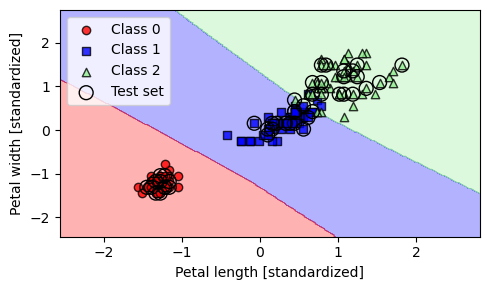

In [47]:
X_combined_std = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plt.figure(figsize=(5, 3))

with torch.no_grad():
    plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=model, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/03_01.png', dpi=300)
plt.show()

In [48]:
class IrisClassifier(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()

        self.layers = torch.nn.Sequential(
            # 1st hidden layer.
            torch.nn.Linear(num_inputs, 30),
            torch.nn.ReLU(),
            
            # 2nd hidden layer.
            torch.nn.Linear(30, 20),
            torch.nn.ReLU(),
            
            # Output layer.
            torch.nn.Linear(20, num_outputs),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

model = IrisClassifier(2, 3)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (epoch) % 20 == 0:
            print(f'Epoch:{epoch:03d}/{num_epochs:03d}'
                  f' | Batch: {i:03d}/{len(train_loader):03d}'
                  f' | Train Loss: {loss:.3f}',
            )

Epoch:000/1000 | Batch: 000/004 | Train Loss: 1.237
Epoch:000/1000 | Batch: 001/004 | Train Loss: 1.022
Epoch:000/1000 | Batch: 002/004 | Train Loss: 1.018
Epoch:000/1000 | Batch: 003/004 | Train Loss: 0.958
Epoch:020/1000 | Batch: 000/004 | Train Loss: 0.090
Epoch:020/1000 | Batch: 001/004 | Train Loss: 0.115
Epoch:020/1000 | Batch: 002/004 | Train Loss: 0.095
Epoch:020/1000 | Batch: 003/004 | Train Loss: 0.033
Epoch:040/1000 | Batch: 000/004 | Train Loss: 0.135
Epoch:040/1000 | Batch: 001/004 | Train Loss: 0.061
Epoch:040/1000 | Batch: 002/004 | Train Loss: 0.081
Epoch:040/1000 | Batch: 003/004 | Train Loss: 0.024
Epoch:060/1000 | Batch: 000/004 | Train Loss: 0.138
Epoch:060/1000 | Batch: 001/004 | Train Loss: 0.056
Epoch:060/1000 | Batch: 002/004 | Train Loss: 0.057
Epoch:060/1000 | Batch: 003/004 | Train Loss: 0.045
Epoch:080/1000 | Batch: 000/004 | Train Loss: 0.005
Epoch:080/1000 | Batch: 001/004 | Train Loss: 0.142
Epoch:080/1000 | Batch: 002/004 | Train Loss: 0.026
Epoch:080/10

In [49]:
model

IrisClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [50]:
# numel returns the number of elements in a tensor.
num_params = 0
for idx, p in enumerate(model.parameters()):
    if p.requires_grad:
        params = p.numel()
        num_params += params
        print(f'({idx}) {params}')

print(f'Number of trainable parameters: {num_params}')

(0) 60
(1) 30
(2) 600
(3) 20
(4) 60
(5) 3
Number of trainable parameters: 773


In [51]:
with torch.no_grad():
    output = model(torch.tensor([0, 0], dtype=torch.float32))
output

tensor([-4.0009,  5.0028, -2.9516])

In [53]:
# Class membership probabilities.
torch.set_printoptions(sci_mode=False)
torch.softmax(output, dim=0)

tensor([    0.0001,     0.9995,     0.0004])

In [56]:
# Predictions. index 0 is for argmax of columns, index 1 is for argmax of the row.
# If we had a matrix of samples, then dim=1 would be the way to go but not here since we have a
# 1D tensor.
# Note that we don't need to apply this to the probabilities obtained from softmax.
torch.argmax(output, dim=0)

tensor(1)

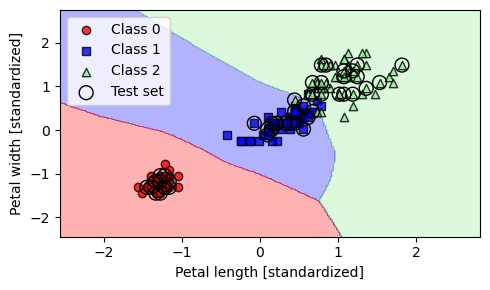

In [54]:
X_combined_std = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plt.figure(figsize=(5, 3))

with torch.no_grad():
    plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=model, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/03_01.png', dpi=300)
plt.show()

In [66]:
def compute_accuracy(model, dataloader):
    model = model.eval()

    correct = 0.0
    total_samples = 0
    for idx, (features, labels) in enumerate(dataloader):
        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)
        correct += torch.sum( predictions == labels )
        total_samples += len(labels)
        
    return correct/total_samples

In [68]:
acc = compute_accuracy(model, test_loader)
acc.item()

1.0

In [69]:
import torch.onnx

In [70]:
torch.save(model.state_dict(), 'model.pth')

In [84]:
model.layers[0].weight[:3, :]

tensor([[-0.6836, -0.5122],
        [ 0.6149, -0.7077],
        [ 0.6509, -0.5345]], grad_fn=<SliceBackward0>)

In [85]:
loaded_model = IrisClassifier(2, 3)
loaded_model

IrisClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [86]:
loaded_model.layers[0].weight[:3, :]

tensor([[-0.1996,  0.6986],
        [ 0.0931,  0.4240],
        [ 0.4155, -0.2217]], grad_fn=<SliceBackward0>)

In [87]:
# FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value),
# which uses the default pickle module implicitly. It is possible to construct malicious pickle
# data which will execute arbitrary code during unpickling
# (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details).
# In a future release, the default value for `weights_only` will be flipped to `True`.
# This limits the functions that could be executed during unpickling.
# Arbitrary objects will no longer be allowed to be loaded via this mode unless they are
# explicitly allowlisted by the user via `torch.serialization.add_safe_globals`.
# We recommend you start setting `weights_only=True` for any use case where you don't have full
# control of the loaded file. Please open an issue on GitHub for any issues related to this
# experimental feature.
loaded_model.load_state_dict(torch.load('model.pth', weights_only=True))

<All keys matched successfully>

In [88]:
loaded_model

IrisClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [89]:
model.layers[0].weight[:3, :]

tensor([[-0.6836, -0.5122],
        [ 0.6149, -0.7077],
        [ 0.6509, -0.5345]], grad_fn=<SliceBackward0>)